# Week 11 Case Study Time Series Facebook Prophet

### Importing Dependencies


In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("google-data.csv")

### Data Understanding

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.shape

(1259, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [ ]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [ ]:
df.Date = df.Date.apply(pd.to_datetime)

#### Removing unnecessary columns

In [ ]:
remove_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
df.drop(remove_cols, axis=1, inplace=True)


In [ ]:
df.head(5)

,Date,Close
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


In [ ]:
#renaming columns
df.columns=["ds", "y"]

In [ ]:
df.head()

,ds,y
0,2013-01-02,359.288177
1,2013-01-03,359.496826
2,2013-01-04,366.600616
3,2013-01-07,365.001007
4,2013-01-08,364.280701


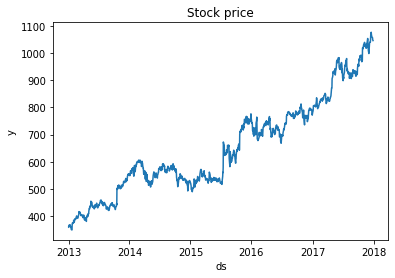

In [ ]:
sns.lineplot(x= df.ds, y= df.y)
plt.title("Stock price")
plt.show()

### Train-Test Split

In [ ]:
train = df.iloc[:-100,]
test = df.iloc[-100:]

### Modelling with Facebook Prophet

In [ ]:
model = Prophet()

In [ ]:
model.fit(train)
forecast = model.make_future_dataframe(periods = 100, freq= "D")
predictions = model.predict(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
forecast.shape

(1259, 1)

In [ ]:
predictions.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,386.997704,344.556239,397.456191,386.997704,386.997704,-14.746664,-14.746664,-14.746664,6.879679,6.879679,6.879679,-21.626343,-21.626343,-21.626343,0.0,0.0,0.0,372.251039
1,2013-01-03,387.169039,345.350581,398.352412,387.169039,387.169039,-16.293346,-16.293346,-16.293346,5.926867,5.926867,5.926867,-22.220213,-22.220213,-22.220213,0.0,0.0,0.0,370.875693
2,2013-01-04,387.340375,342.604048,398.036937,387.340375,387.340375,-16.544963,-16.544963,-16.544963,6.222136,6.222136,6.222136,-22.767100,-22.767100,-22.767100,0.0,0.0,0.0,370.795412
3,2013-01-07,387.854382,340.336680,396.068417,387.854382,387.854382,-18.135633,-18.135633,-18.135633,5.974312,5.974312,5.974312,-24.109944,-24.109944,-24.109944,0.0,0.0,0.0,369.718749
4,2013-01-08,388.025718,343.566769,397.459502,388.025718,388.025718,-18.246958,-18.246958,-18.246958,6.210030,6.210030,6.210030,-24.456988,-24.456988,-24.456988,0.0,0.0,0.0,369.778760


In [ ]:
preds = predictions[["ds", "yhat"]]

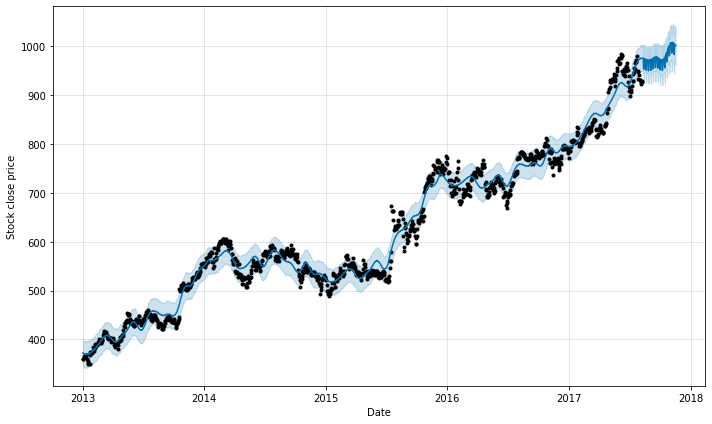

In [ ]:
model.plot(predictions, xlabel = "Date", ylabel= "Stock close price");

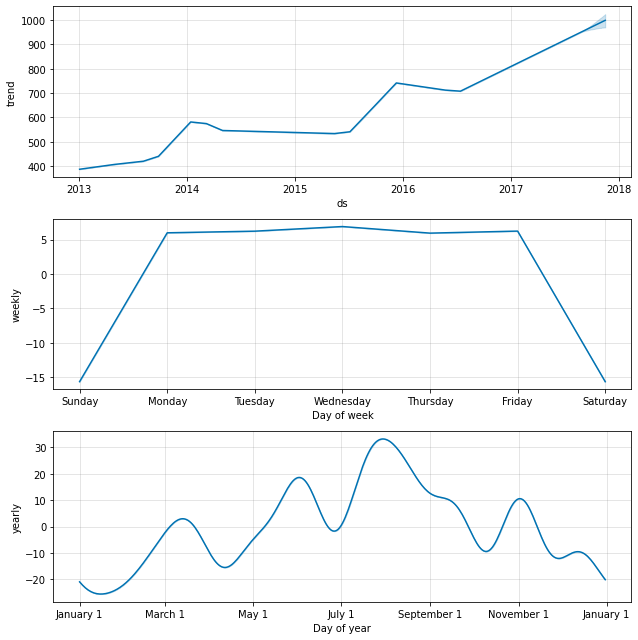

In [ ]:
model.plot_components(predictions);

In [ ]:
y_pred = preds.iloc[-100:, 1]
y_test = test.y

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_t, y_p):
  return float(np.sqrt(mean_squared_error(y_true= y_test, y_pred= y_pred)))

In [ ]:
rmse(y_test, y_pred)

44.31477243427674

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.9 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 209 kB 42.3 MB/s 
     |████████████████████████████████| 75 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 52.4 MB/s 
     |████████████████████████████████| 111 kB 52.3 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=aea236c9cc3f25ece31f5a614dabecd99720b60af13dd6fe84fa67d1c37eb343
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


### Bayesian optimization of parameters 

In [ ]:
import optuna
from fbprophet.diagnostics import cross_validation, performance_metrics

In [ ]:
m = Prophet()
m.fit(df) 

number_initial_days = 366

df_cv = cross_validation(m,
                         initial=f'{number_initial_days} days', 
                         period='90 days', 
                         horizon = '100 days',
                         parallel='processes')

df_p = performance_metrics(df_cv)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed9e92dd0>


In [ ]:
param_types = {'changepoint_prior_scale': 'float', 
               'seasonality_prior_scale': 'float',
              'seasonality_mode': 'int'}

bounds = {'changepoint_prior_scale': [0.01, 0.5],
          'seasonality_prior_scale': [0.1, 10],
          'seasonality_mode': [0, 1]}  #0 for additive, 1 for multiplicative

In [ ]:
def objective(trial):
    '''Train a prophet model and return the rmse'''
    # sampling
    params = {}
    for param in ['changepoint_prior_scale', 'seasonality_prior_scale']:
        params[param] = trial.suggest_uniform(param, bounds[param][0], bounds[param][1])
        
    stationality = ['additive', 'multiplicative']
    params['seasonality_mode'] = stationality[trial.suggest_int('seasonality_mode', 
                                                                  bounds['seasonality_mode'][0], 
                                                                  bounds['seasonality_mode'][1])]

    # modeling
    m = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)
    
    m.fit(df) 
    number_initial_days = 366
    df_cv = cross_validation(m, 
                             initial=f'{number_initial_days} days', 
                             period='90 days', 
                         horizon = '100 days',
                         parallel='processes')
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p['mape'].mean())
    
    return df_p['rmse'].values[0]

In [ ]:
s_param = optuna.create_study()
s_param.optimize(objective, n_trials = 10)

[I 2021-10-23 21:50:44,077] A new study created in memory with name: no-name-f8e73049-c3b7-4d90-b314-cc76043254a3
INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed55a2a50>
[I 2021-10-23 21:51:18,448] Trial 0 finished with value: 73.1561466854589 and parameters: {'changepoint_prior_scale': 0.013633785094157781, 'seasonality_prior_scale': 3.960219613122704, 'seasonality_mode': 0}. Best is trial 0 with value: 73.1561466854589.


0.08489403511731586


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed8926d10>
[I 2021-10-23 21:52:47,298] Trial 1 finished with value: 90.44588571762833 and parameters: {'changepoint_prior_scale': 0.1006034265193235, 'seasonality_prior_scale': 3.996475210999232, 'seasonality_mode': 1}. Best is trial 0 with value: 73.1561466854589.


0.09713263092457085


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6f1db6f090>
[I 2021-10-23 21:54:10,088] Trial 2 finished with value: 143.37609436859762 and parameters: {'changepoint_prior_scale': 0.4566991972486736, 'seasonality_prior_scale': 2.3770609431868297, 'seasonality_mode': 1}. Best is trial 0 with value: 73.1561466854589.


0.1596757991694155


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed55a2a90>
[I 2021-10-23 21:54:45,236] Trial 3 finished with value: 72.98410655078236 and parameters: {'changepoint_prior_scale': 0.017762736960959057, 'seasonality_prior_scale': 1.186767508277789, 'seasonality_mode': 0}. Best is trial 3 with value: 72.98410655078236.


0.08443668993115265


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed5262cd0>
[I 2021-10-23 21:55:42,778] Trial 4 finished with value: 89.22728274267931 and parameters: {'changepoint_prior_scale': 0.3319075275874244, 'seasonality_prior_scale': 2.2219200810822826, 'seasonality_mode': 0}. Best is trial 3 with value: 72.98410655078236.


0.09885882490291142


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed5256c90>
[I 2021-10-23 21:57:01,665] Trial 5 finished with value: 134.16280229726024 and parameters: {'changepoint_prior_scale': 0.37858442518202123, 'seasonality_prior_scale': 2.408509585129122, 'seasonality_mode': 1}. Best is trial 3 with value: 72.98410655078236.


0.14704906873337215


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed52ac950>
[I 2021-10-23 21:58:01,415] Trial 6 finished with value: 84.91100838039691 and parameters: {'changepoint_prior_scale': 0.4910123276965381, 'seasonality_prior_scale': 2.2097528638845176, 'seasonality_mode': 0}. Best is trial 3 with value: 72.98410655078236.


0.09164814445486154


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed6ed19d0>
[I 2021-10-23 21:58:59,033] Trial 7 finished with value: 89.2047100986376 and parameters: {'changepoint_prior_scale': 0.3202203121987172, 'seasonality_prior_scale': 2.3761928828755488, 'seasonality_mode': 0}. Best is trial 3 with value: 72.98410655078236.


0.09891071210349142


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed51c0810>
[I 2021-10-23 22:00:25,102] Trial 8 finished with value: 120.42867644296729 and parameters: {'changepoint_prior_scale': 0.22541831311233096, 'seasonality_prior_scale': 4.210012835456448, 'seasonality_mode': 1}. Best is trial 3 with value: 72.98410655078236.


0.12938845473133107


INFO:fbprophet:Making 16 forecasts with cutoffs between 2014-01-09 00:00:00 and 2017-09-20 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f6ed6ed19d0>
[I 2021-10-23 22:01:49,774] Trial 9 finished with value: 140.28413507202794 and parameters: {'changepoint_prior_scale': 0.47826889325449995, 'seasonality_prior_scale': 9.116763558701946, 'seasonality_mode': 1}. Best is trial 3 with value: 72.98410655078236.


0.15770016058255576


In [ ]:
s_param.best_params

{'changepoint_prior_scale': 0.017762736960959057,
 'seasonality_mode': 0,
 'seasonality_prior_scale': 1.186767508277789}

### Predictinf for the next 100 days

In [ ]:
params = s_param.best_params
params["seasonality_mode"] = "additive"

In [ ]:
model = Prophet(weekly_seasonality=True,
                daily_seasonality=False,
                **params)

model.fit(train)
forecast = model.make_future_dataframe(periods = 100, freq= "D")
predictions = model.predict(forecast)
preds = predictions[["ds", "yhat"]]
y_pred = preds.iloc[-100:, 1]
y_test = test.y

In [ ]:
rmse(y_test, y_pred)

38.526672440177215

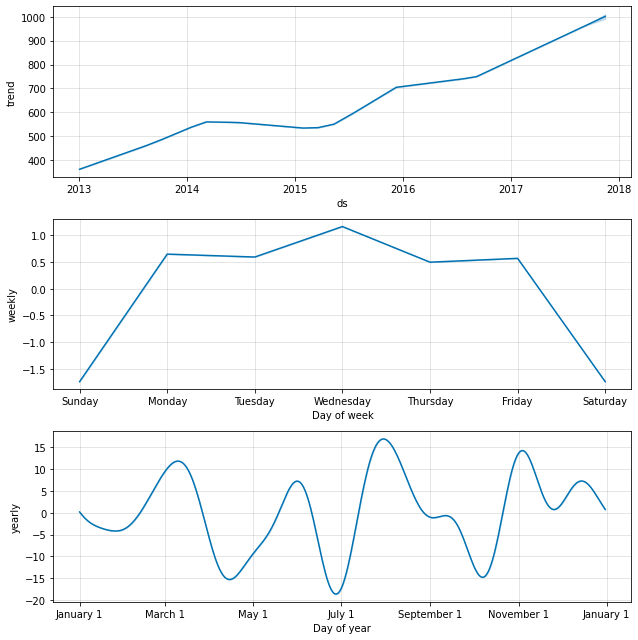

In [ ]:
model.plot_components(predictions);